# Amazon reviews analysis 


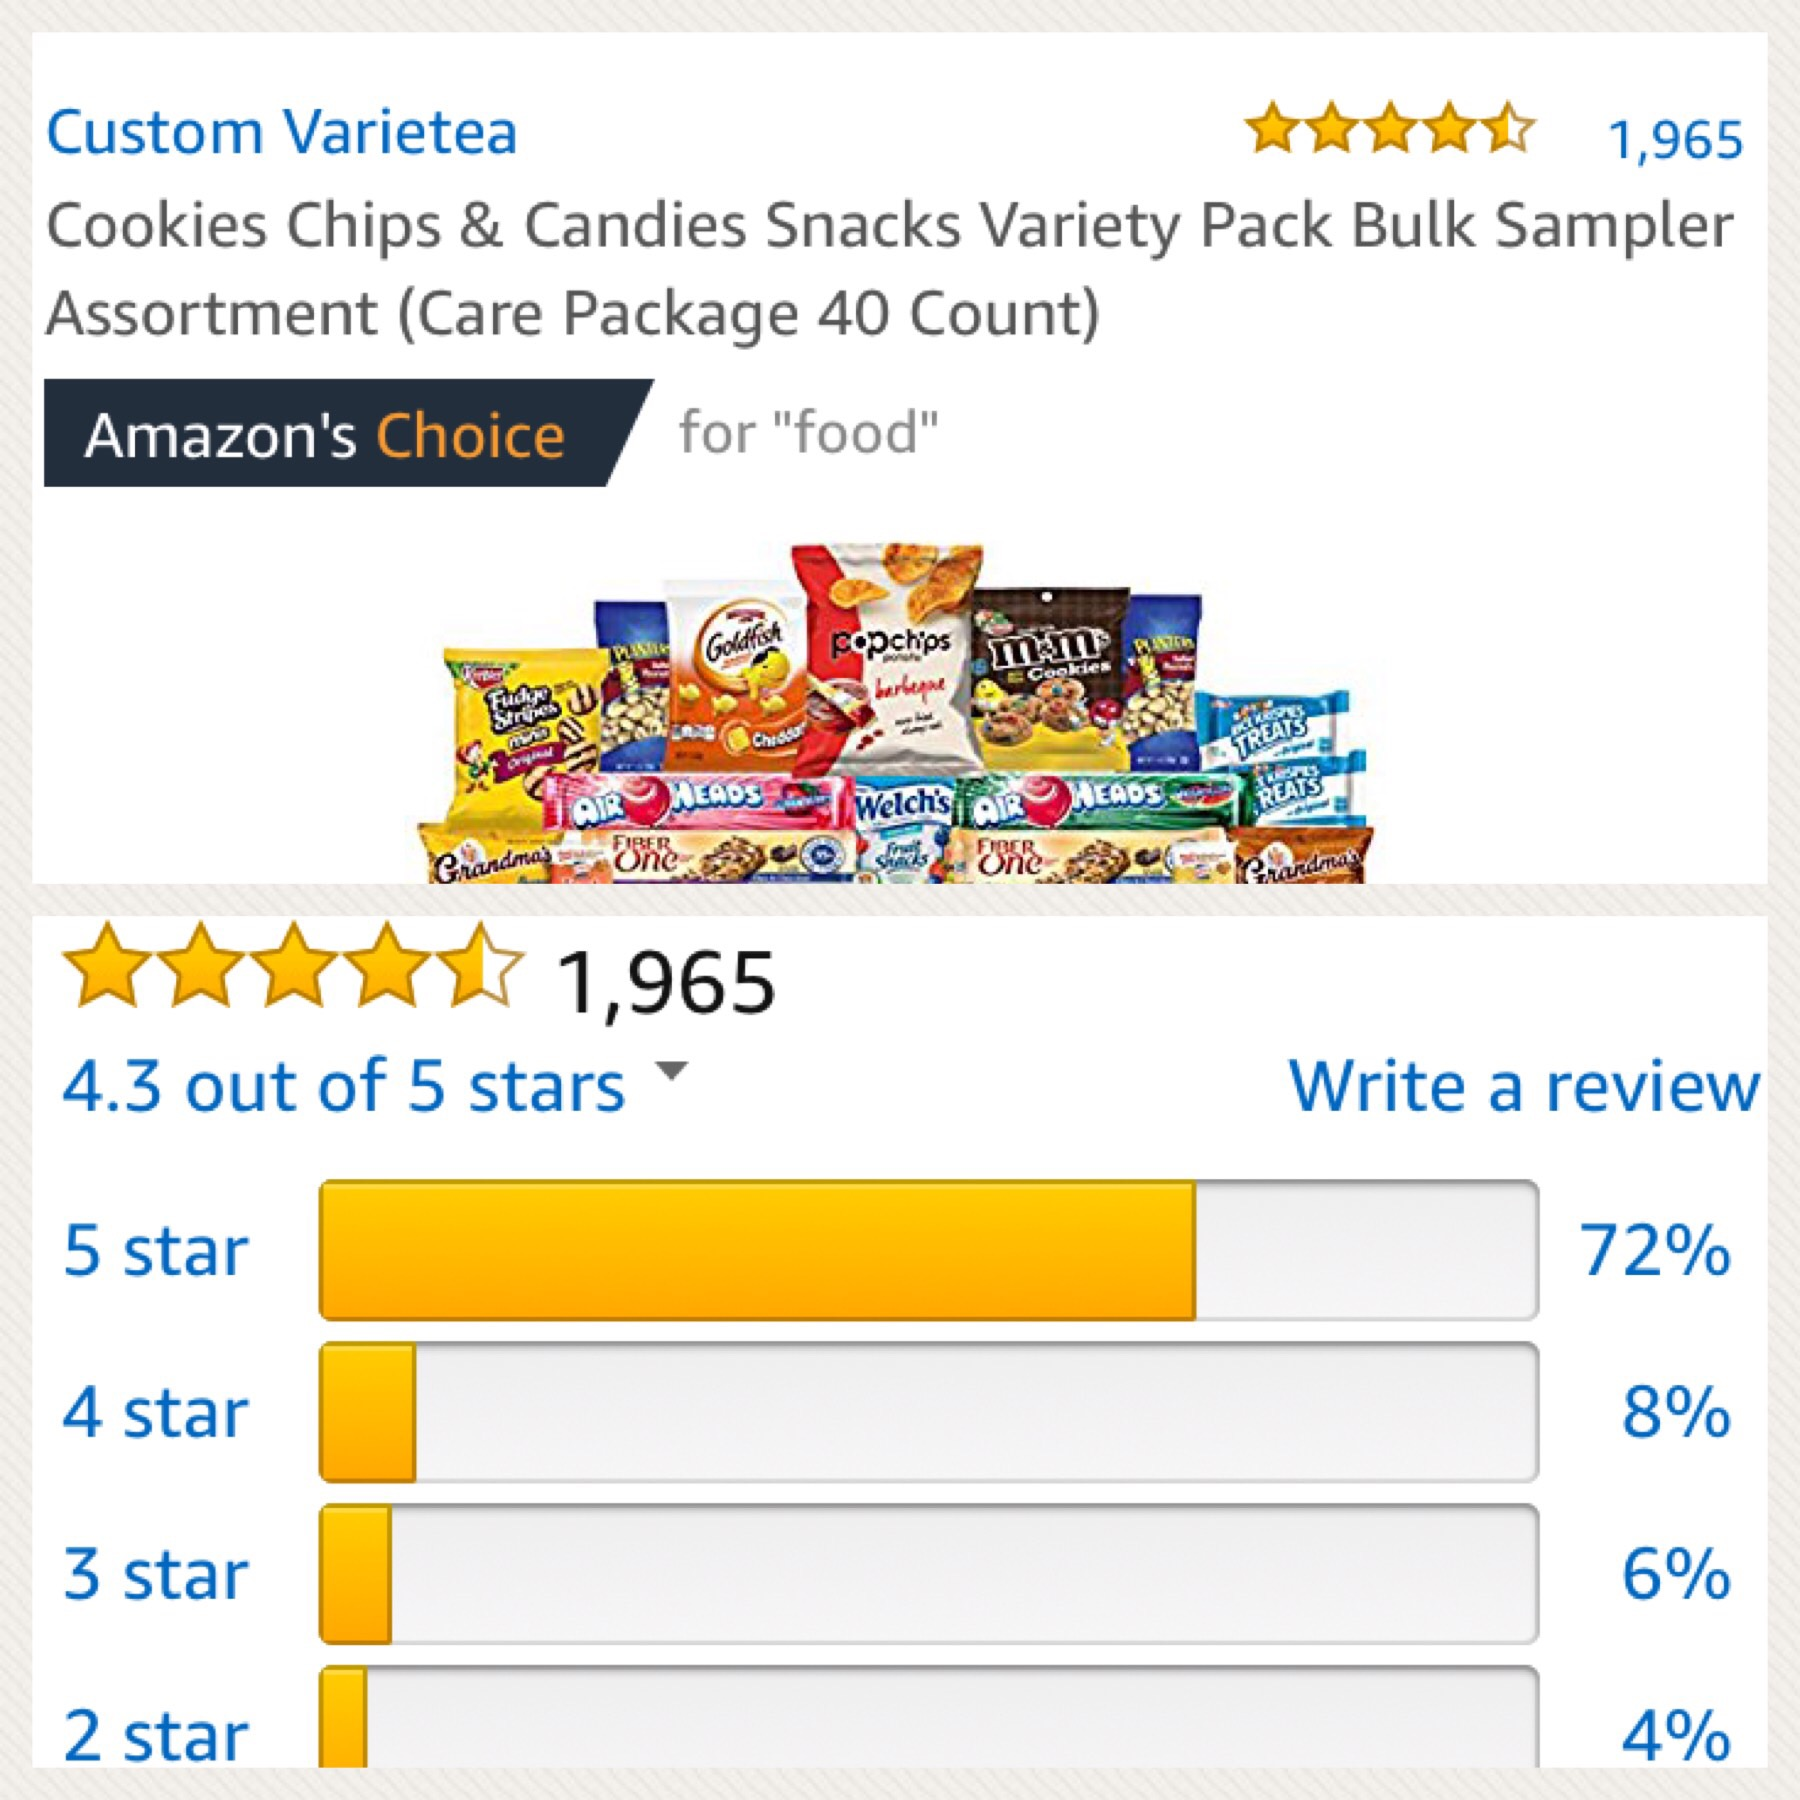

In [1]:
from IPython.display import Image
Image(filename='amazon.png')
Image(filename='IMG_3294.JPG')

# Project Overview 

Background: Recently more and more Amazon sellers realized how customers’ reviews can impact other buyers’ decision making. Since most of customers will hesitate to make a purchase decision if the product has a negative review.  As an analyst, my goal is to help the business to provide the good shopping experience. So, I want to develop the model to predict if a review is helpful or not helpful from sentiment analysis.  Then the modeling outcome will help Amazon’s merchants have better understand about customers’ attitudes towards reviews.

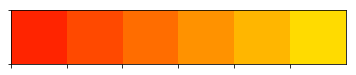

In [15]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from pandas import Series, DataFrame, datetime
from subprocess import check_output
from datetime import datetime, timedelta, time
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as cm
import seaborn as sns
aut=sns.palplot(sns.color_palette("autumn"))

# 1. Data Preparation 

## Clean Numeric Data
+ Clean missing value
+ Check duplicate 

In [16]:
amazon = pd.read_csv('Reviews.csv',index_col=0)
amazon.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


+ Id
+ ProductId - unique identifier for the product
+ UserId - unqiue identifier for the user
+ ProfileName
+ HelpfulnessNumerator - number of users who found the review helpful
+ HelpfulnessDenominator - number of users who indicated whether they found the review helpful
+ Score - rating between 1 and 5
+ Time - timestamp for the review
+ Summary - brief summary of the review
+ Text - text of the review

In [17]:
#check number of observations and row
print (amazon.shape)

(568454, 9)


In [18]:
#check missing value 
amazon.isnull().sum()

ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   26
Text                       0
dtype: int64

In [19]:
# Since majority of data has value, we can just remove missing values
amazon= amazon.dropna(subset=['ProfileName','Summary'])
amazon.isnull().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [20]:
#check number of observations and row after removed missing value
print (amazon.shape)

(568412, 9)


In [21]:
# covert time
amazon['date_time']=pd.to_datetime(amazon['Time'],unit='s')
amazon['date']=pd.to_datetime(amazon['date_time'],unit='d')
amazon['date1'] = pd.to_datetime(amazon['date'])
amazon['year']=amazon.date1.dt.year
amazon.date_time.describe()

count                  568412
unique                   3168
top       2012-10-16 00:00:00
freq                     1143
first     1999-10-08 00:00:00
last      2012-10-26 00:00:00
Name: date_time, dtype: object

In [22]:
# check HelpfulnessDenominator
amazon.HelpfulnessDenominator.describe()

count    568412.000000
mean          2.227872
std           8.288745
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         923.000000
Name: HelpfulnessDenominator, dtype: float64

In [23]:
# check percentage of Helpful
amazon['Helpful_pct'] = amazon['HelpfulnessNumerator'] / amazon['HelpfulnessDenominator']
amazon.loc[amazon.HelpfulnessDenominator==0,'Helpful_pct']=0
amazon['Helpful_pct'].describe()

count    568412.000000
mean          0.407883
std           0.462073
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: Helpful_pct, dtype: float64

In [24]:
# divided the reviews into four categories
def partition(x):
    if x >=0.75:
        return '75'
    elif x>=0.5:
        return '50'
    elif x>=0.25 :
        return '25'
    return '0'
amazon['help1'] = amazon['Helpful_pct'].map(partition)
amazon['help1'].describe()

count     568412
unique         4
top            0
freq      308295
Name: help1, dtype: object

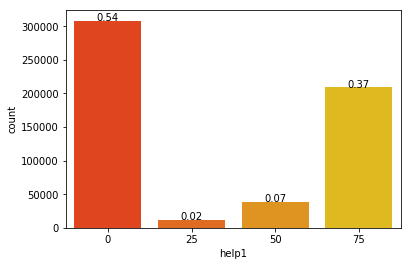

In [25]:
total = float(len(amazon)) 
ax = sns.countplot(x="help1",palette='autumn', data=amazon) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show()

#### Among all reviews, more then 50% are not voted on at all. More than 35% of voters find the review helpful.

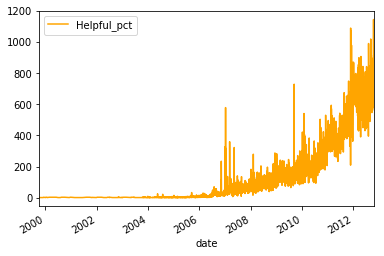

In [26]:
## Helpfulness count, reviews has increased 
time1=amazon[['date','Helpful_pct']].copy()
time1['Helpful_pct']=amazon.groupby(['date']).Helpful_pct.transform('count')
time1.set_index(['date'],inplace=True)
time1.sort_index(inplace=True)
time1.plot(color='orange')

#### 1. After remove missing value the dataset contains 568,412 food reviews from Amazon users left from 1999 Oct to 2012 Oct. 
#### 2. Reviews has increased over years.

In [27]:
avg_help_pct=amazon.groupby(['year']).Helpful_pct.mean().reset_index().sort_values(by='year')
avg_help_pct

,year,Helpful_pct
0,1999,0.416667
1,2000,0.649432
2,2001,0.600230
3,2002,0.580093
4,2003,0.667129
5,2004,0.693606
6,2005,0.716568
7,2006,0.701132
8,2007,0.650633
9,2008,0.560857


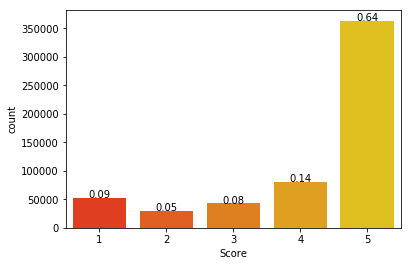

In [28]:
total = float(len(amazon)) # one person per row 
#ax = sns.barplot(x="class", hue="who", data=titanic)
ax = sns.countplot(amazon['Score'],color="orange",palette='autumn') # for Seaborn version 0.7 and more
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.show()

In [29]:
print("Average Score: ",np.mean(amazon.Score))
print("Median Score: ",np.median(amazon.Score))

Average Score:  4.183307178595808
Median Score:  5.0


####  The distribution of rating among all of the reviews. We see that 5-star reviews constitute a large proportion (64%) of all reviews. The next most prevalent rating is 4-stars(14%), followed by 1-star (9%), 3-star (8%), and finally 2-star reviews (5%). Majority of Scores are around 4 to 5, and average score is 4.18. The distribution is very skewed to the left. 

### Summary of dataset statistics 
+ Number of reviews : 393,566
+ Number of unique users : 256,048 
+ Number of unique products :74,258

In [30]:
review= amazon['UserId'].groupby(amazon['Text']).count()
print(review.count())
User= amazon['Score'].groupby(amazon['UserId']).count()
print(User.count())
products = amazon['Score'].groupby(amazon['ProductId']).count()
print(products.count())

393566
256048
74258


In [31]:
amazon['chk']=amazon.duplicated(['Text'])
amazon['chk'].sum()

174846

## Cleaning Text
+ Using lemmatization as it was giving better results than stemming.  
+ lower case 
+ Removing punctuation and stopwords

In [32]:
from scipy.misc import imread
from PIL import Image
import numpy as np
import re
import matplotlib as mpl
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mirabooboo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mirabooboo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
lemmatizer = nltk.WordNetLemmatizer()
# translation = str.maketrans(string.punctuation,' '*len(string.punctuation))
stemmer = PorterStemmer()
stop = stopwords.words('english')
def preprocessing(line):
    tokens=[]
    line= nltk.word_tokenize(line.lower())
#     line = line.translate(translation)
    for w in line:
        if(w not in stop):
#             stemmed = stemmer.stem(w)
            stemmed = lemmatizer.lemmatize(w)
            tokens.append(stemmed)
    return ' '.join(tokens)

In [ ]:
    line= re.sub(r'\<a href', ' ', line)
    line= re.sub(r'&amp;', '', line) 
    line= re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', line)
    line= re.sub(r'<br />', ' ', line)
    line= re.sub(r'\'', ' ', line)

In [38]:
amazon["Summary1"] = amazon["Summary"].apply(preprocessing)

In [39]:
amazon["text_Clean1"] = amazon["Text"].apply(preprocessing)

In [37]:
amazon["text_Clean1"].head(5)

Id
1    bought several vitality canned dog food produc...
2    product arrived labeled jumbo salted peanut pe...
3    confection around century light pillowy citrus...
4    looking secret ingredient robitussin believe f...
5    great taffy great price wide assortment yummy ...
Name: text_Clean1, dtype: object

In [38]:
amazon["word_cnt"] = amazon['Text'].str.split().str.len()
amazon["word_cnt"].describe()

count    568412.000000
mean         80.267303
std          79.457074
min           3.000000
25%          33.000000
50%          56.000000
75%          98.000000
max        3432.000000
Name: word_cnt, dtype: float64

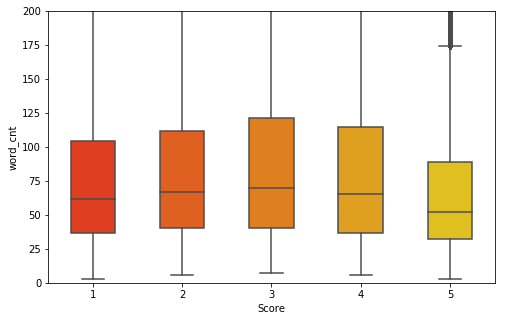

In [39]:
plt.figure(figsize=(8,5))
plt.ylim(0, 200)
# Change line width
sns.boxplot( x=amazon["Score"], y=amazon["word_cnt"], width=0.5,palette='autumn')
plt.show()

In [40]:
# save clean data 
amazon.to_csv('amazon_clean.csv')

## All reviews word cloud

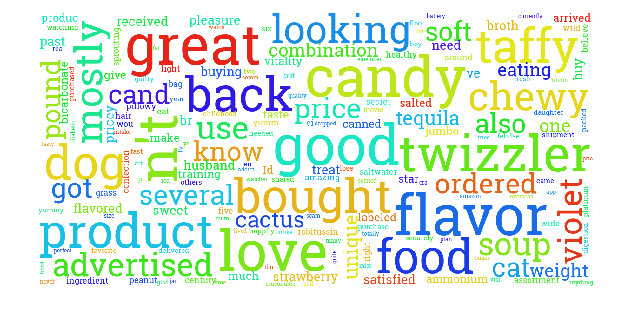

In [40]:
from colormap import Colormap
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
from os import path
import os
mpl.rcParams['font.size']=12                
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        font_path=os.path.join('fonts', 'RobotoSlab-Regular.ttf'),
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
#         Colormap="terrain",
        scale=3
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(10, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=14)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(amazon["text_Clean1"]) 

## Low Score reviews word cloud 

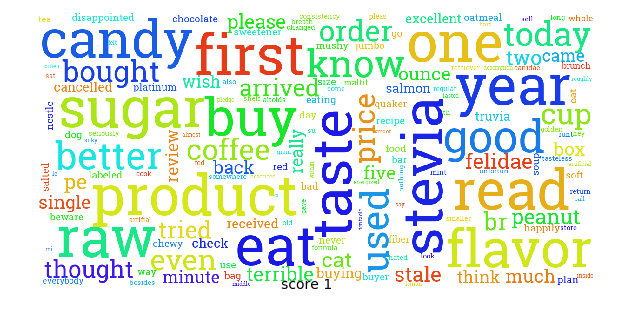

In [56]:
show_wordcloud(amazon[amazon.Score == 1]["text_Clean1"], title = "score 1")

## High Score reviews word cloud

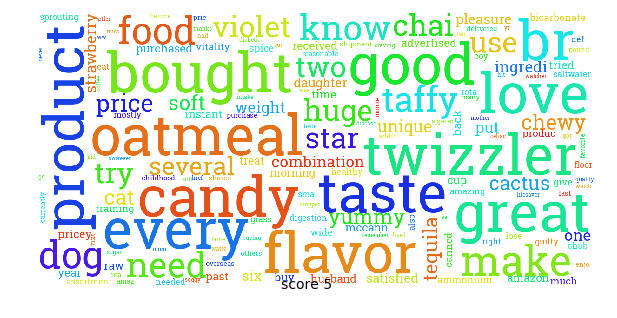

In [46]:
show_wordcloud(amazon[amazon.Score == 5]["text_Clean1"], title = "score 5")

In [43]:
word_his = pd.DataFrame(Counter(" ".join(amazon['Summary1']).split()).most_common(20),columns=['words','count'])

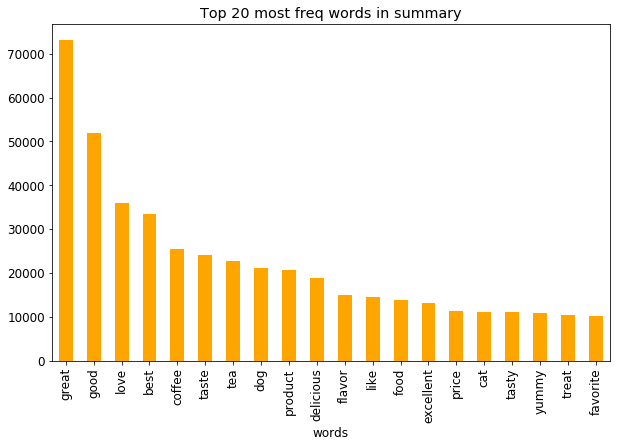

In [47]:
word_his.plot(kind='bar',x=word_his['words'],legend=False,title='Top 20 most freq words in summary',figsize=(10,6), color="orange")

In [45]:
word_Txt_his = pd.DataFrame(Counter(" ".join(amazon['text_Clean1']).split()).most_common(20),columns=['word_Txt','count'])

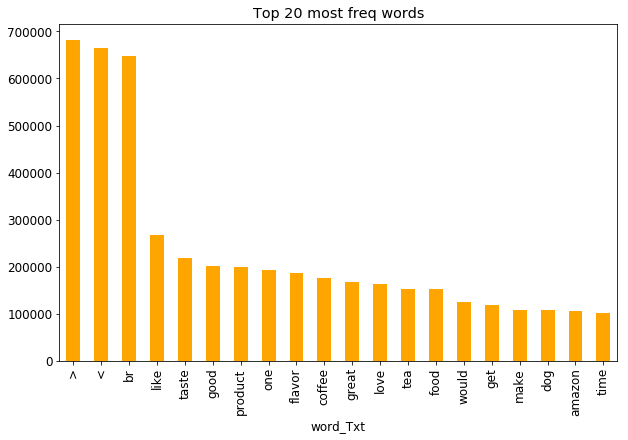

In [46]:
word_Txt_his.plot(kind='bar',x=word_Txt_his['word_Txt'],legend=False,title='Top 20 most freq words',figsize=(10,6), color="orange")

# 2. Modeling -Define target variable

In [41]:
df = pd.read_csv('amazon_clean.csv')
df.shape

(568412, 20)

In [42]:
#set up target variable -transform Helpfulness into a binary variable
threshold = 0.7
df.loc[:, 'Helpful'] = np.where(df.loc[:, 'HelpfulnessNumerator'] \
                                 / df.loc[:, 'HelpfulnessDenominator'] > threshold, 1, 0)
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,date,date1,year,Helpful_pct,help1,chk,Summary1,text_Clean1,word_cnt,Helpful
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,...,2011-04-27,2011-04-27,2011,1.0,75,False,good quality dog food,bought several vitality canned dog food produc...,48,1


#### Here I label the training data as 'helpful' = 1, or 'not-helpful' = 0. The threshold is arbitrarily set to 0.8 becuase higher value can filter the help and non-helpful reviews better.

In [51]:
print ('Count:')
df.Helpful.value_counts() 

Count:


0    370463
1    197949
Name: Helpful, dtype: int64

In [52]:
NO=(370463)/(370463+197949)
print (NO)

0.651750842698606


#### Helpful vs helpless is 34% VS 65% 

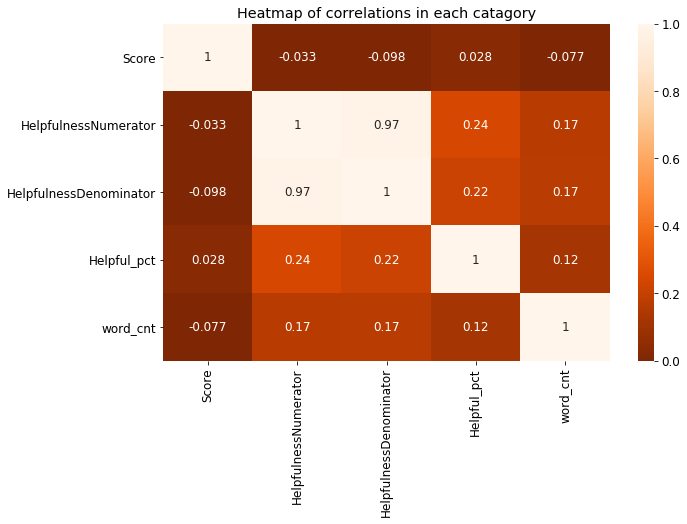

In [55]:
#Visualize correlation of the data
plt.figure(figsize=(10,6))
corr1=df[['Score','HelpfulnessNumerator','HelpfulnessDenominator','Helpful_pct','word_cnt']]
correlations = corr1.corr()
plt.title("Heatmap of correlations in each catagory")
_ = sns.heatmap(correlations, vmin=0, vmax=1, cmap='Oranges_r',annot=True) 

# Modeling :
+ Select sample  
+ Split training and testing  80% VS 20%

In [43]:
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
RAN_STATE =42

#### Business environment changes very fast espeically  ecommerce field, 2002's situation may not apply today's business world so we only consider past 9 years data. 

In [44]:
print ('Count:')
df.year.value_counts() 

Count:


2012    198655
2011    163289
2010     85881
2009     55326
2008     34163
2007     22275
2006      6671
2005      1335
2004       561
2003       132
2002        73
2000        32
2001        13
1999         6
Name: year, dtype: int64

In [45]:
##include reviews that have more than 3 helpfulness data point only
final_df= df[(df.HelpfulnessDenominator >= 3) & (df.year>=2009)].copy()
final_df.shape

(94368, 21)

In [46]:
print ('Count:')
final_df.Helpful.value_counts() 

Count:


1    60311
0    34057
Name: Helpful, dtype: int64

In [47]:
bag1= final_df[final_df.Helpful==1]
bag2= final_df[final_df.Helpful==0]
bag1_sample=bag1.sample(40000)
df_upsampled1 = pd.concat([bag2 , bag1_sample])
df_upsampled1.shape

(74057, 21)

In [48]:
print ('Count:')
df_upsampled1.Helpful.value_counts() 

Count:


1    40000
0    34057
Name: Helpful, dtype: int64

In [61]:
# from sklearn.utils import resample
# bag1= final_df[final_df.Helpful==1]
# bag2= final_df[final_df.Helpful==0]
# bag1_sample=bag1.sample(60000)
# df_final_upsampled = resample(bag2, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=60000,    # to match majority class
#                                  random_state=123) # reproducible results
# # Combine majority class with upsampled minority class
# df_upsampled1 = pd.concat([df_final_upsampled , bag1_sample])
# df_upsampled1.shape

(120000, 21)

In [49]:
df_upsampled2=df_upsampled1[['Helpful','text_Clean1']].copy()
df_upsampled2.shape

(74057, 2)

In [50]:
#create a stemmer
stemmer = SnowballStemmer("english")
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
    #fit the vectorizers to the data.
features = vectorizer.fit_transform(df_upsampled2['text_Clean1'])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(features,df_upsampled2['Helpful'], test_size=0.3, random_state=RAN_STATE)

In [52]:
print("X_train shape: {}".format(X_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n')
print("X_test shape: {}".format(X_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n')

X_train shape: (51839, 777)
y_train shape: (51839,)
X_test shape: (22218, 777)
y_test shape: (22218,)


In [70]:
# Import the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import grid_search

In [60]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.2f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on roc_auc score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    probas = clf.predict_proba(features)
    end = time()
    
    # Print and return results
    print ("Made predictions in {:.2f} seconds.".format(end - start))
    return roc_auc_score(target.values, probas[:,1].T)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on roc_auc score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, X_train.shape[0]))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print ("ROC_AUC score for training set: {:.2f}.".format(predict_labels(clf, X_train, y_train)))
    print ("ROC_AUC score for test set: {:.2f}.\n".format(predict_labels(clf, X_test, y_test)))
    
def clf_test_roc_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    probas = probas =clf.predict_proba(X_test)
    return roc_auc_score(y_test, probas[:,1].T)

In [61]:
#Random state for classifiers
RAN_STATE = 42
# Initialize the models using a random state were applicable.
clf_list = [GaussianNB(), 
            XGBClassifier(random_state = RAN_STATE),
            AdaBoostClassifier(random_state = RAN_STATE),
            RandomForestClassifier(random_state = RAN_STATE), 
            LogisticRegression(random_state = RAN_STATE),
            DecisionTreeClassifier(random_state = RAN_STATE)]
x_tr = X_train.toarray()
x_te = X_test.toarray()

# Set up the training set sizes for 10000, 20000 and 30000 respectively.
train_feature_list = [x_tr[0:10000],x_tr[0:20000],x_tr]
train_target_list = [y_train[0:10000], y_train[0:20000], y_train]


# Execute the 'train_predict' function for each of the classifiers and each training set size
for clf in clf_list:
    for a, b in zip(train_feature_list, train_target_list):
        train_predict(clf, a, b, x_te, y_test)

Training a GaussianNB using a training set size of 10000. . .
Trained model in 0.18 seconds
Made predictions in 0.14 seconds.
ROC_AUC score for training set: 0.72.
Made predictions in 0.55 seconds.
ROC_AUC score for test set: 0.67.

Training a GaussianNB using a training set size of 20000. . .
Trained model in 0.29 seconds
Made predictions in 0.25 seconds.
ROC_AUC score for training set: 0.70.
Made predictions in 0.38 seconds.
ROC_AUC score for test set: 0.68.

Training a GaussianNB using a training set size of 51839. . .
Trained model in 0.79 seconds
Made predictions in 0.95 seconds.
ROC_AUC score for training set: 0.70.
Made predictions in 0.36 seconds.
ROC_AUC score for test set: 0.69.

Training a XGBClassifier using a training set size of 10000. . .
Trained model in 23.56 seconds
Made predictions in 0.11 seconds.
ROC_AUC score for training set: 0.80.
Made predictions in 0.21 seconds.
ROC_AUC score for test set: 0.72.

Training a XGBClassifier using a training set size of 20000. . .

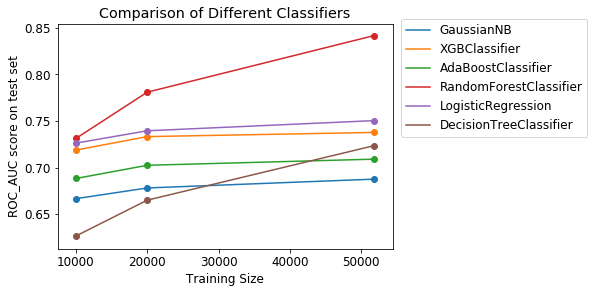

In [62]:
### Visualize differnet type of classifiers                                                               
FIG_SIZE = (26,20)
for clf in clf_list:
    x_graph = []
    y_graph = []
    for a, b in zip(train_feature_list, train_target_list):
        y_graph.append(clf_test_roc_score(clf, a, b, x_te, y_test))
        x_graph.append(len(a))
    plt.scatter(x_graph,y_graph)
    plt.plot(x_graph,y_graph, label = clf.__class__.__name__)

plt.title('Comparison of Different Classifiers')
plt.xlabel('Training Size')
plt.ylabel('ROC_AUC score on test set')
plt.legend(bbox_to_anchor=(1.6, 1.05))
plt.figure(figsize=FIG_SIZE)             
plt.show()

In [63]:
X_train2, X_test2, y_train, y_test = train_test_split(features, df_upsampled2['Helpful'], test_size=0.2, random_state=RAN_STATE)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [65]:
from sklearn import grid_search
#make the grid search object
gs2 = grid_search.GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1,max_features='auto', random_state=42),
    param_grid={ 
           "n_estimators" : [200,400,800],
           "max_depth" : [5, 10, 20],
           "min_samples_leaf" : [2, 4]}
)
#fit the grid search object to our new dataset
print ('Fitting grid search...')
gs2.fit(X_train2, y_train)
print ("Grid search fitted.")

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting grid search...
Grid search fitted.


In [66]:
#print the grid search scores.
print (gs2.best_estimator_)
gs2.grid_scores_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


[mean: 0.61055, std: 0.00498, params: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 200},
 mean: 0.61529, std: 0.00347, params: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 400},
 mean: 0.61843, std: 0.00297, params: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 800},
 mean: 0.61018, std: 0.00527, params: {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 200},
 mean: 0.61494, std: 0.00372, params: {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 400},
 mean: 0.61739, std: 0.00273, params: {'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 800},
 mean: 0.68316, std: 0.00137, params: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200},
 mean: 0.68254, std: 0.00121, params: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 400},
 mean: 0.68340, std: 0.00117, params: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 800},
 mean: 0.67989, std: 0.00273, params: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 20

ROC_AUC Score: 0.818675113303


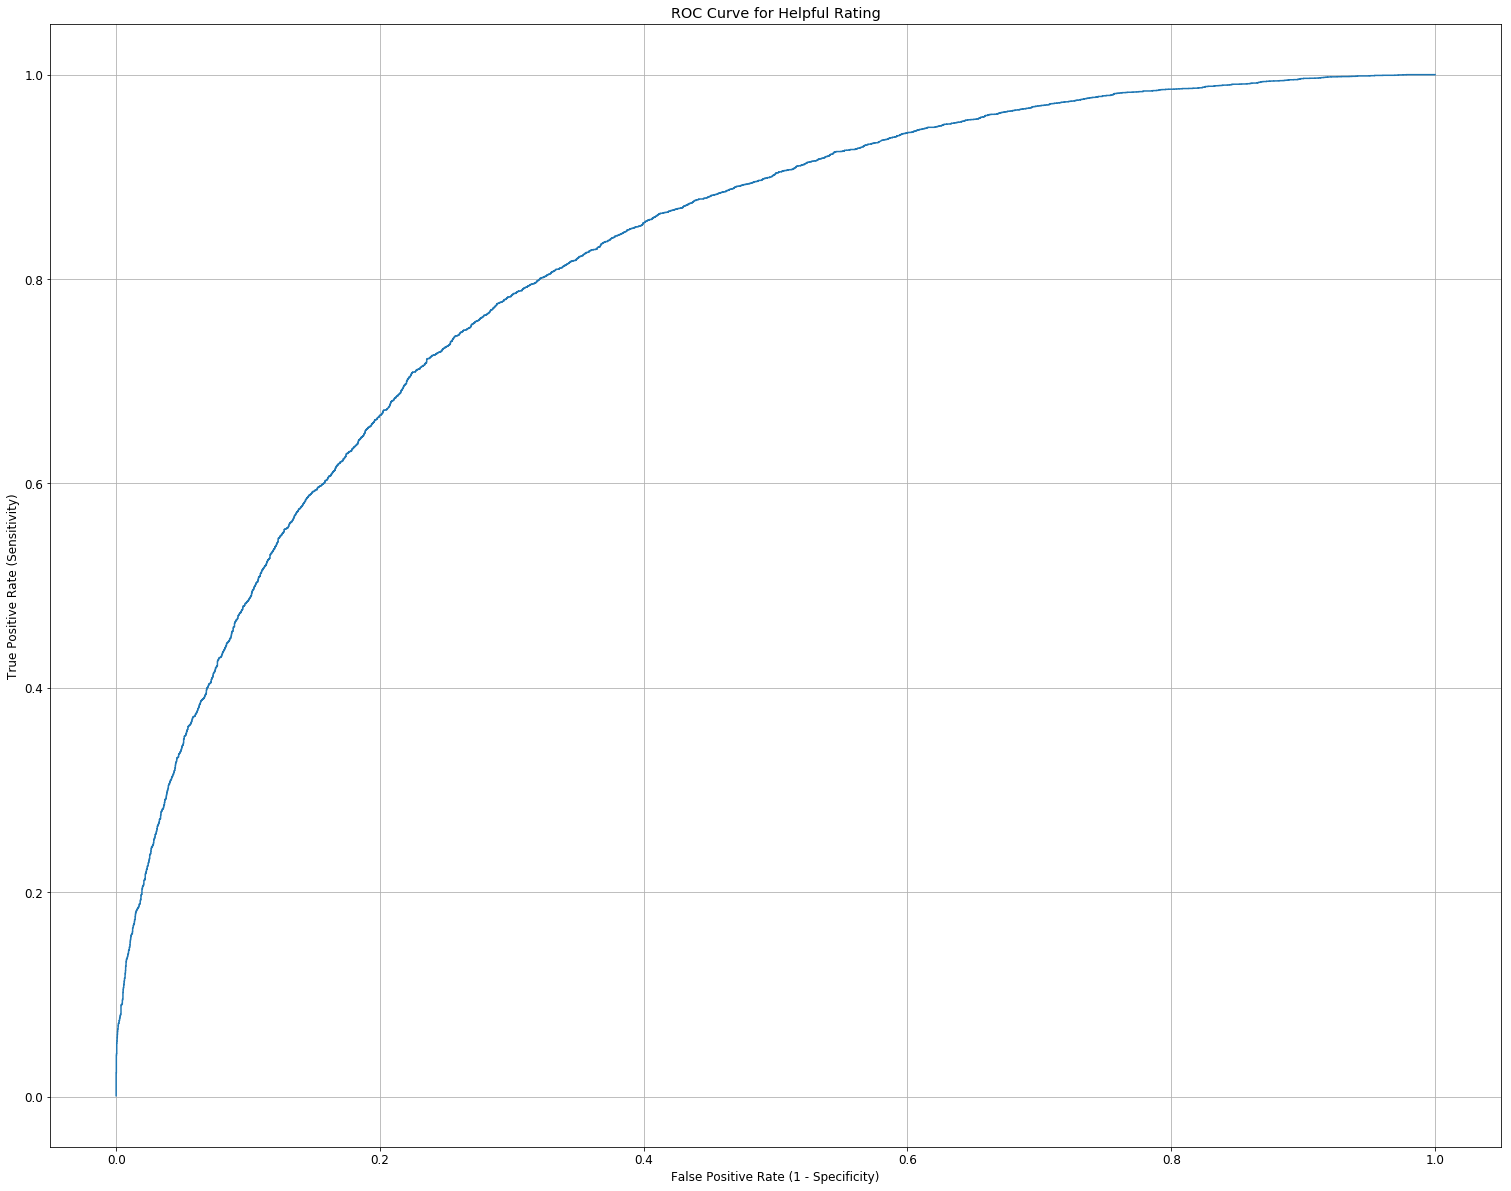

In [125]:
clf2 = gs2.best_estimator_
probas =clf2.predict_proba(X_test2)
plt.figure(figsize = FIG_SIZE)
plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1])
plt.title('ROC Curve for Helpful Rating')
plt.grid()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show

# ROC/AUC score
print ('ROC_AUC Score:',roc_auc_score(y_test, probas[:,1].T))

In [126]:
random_numbers = range(1,101)
tot = 0.0
for seed in random_numbers:
    clf3 = RandomForestClassifier(random_state = seed)
    clf3.fit(X_train2, y_train)
    probas =clf3.predict_proba(X_test2)
    tot += roc_auc_score(y_test, probas[:,1].T)
    
print ('Average ROC_AUC Score for 1-100 random_state: {:.4f}'.format(tot/100))

Average ROC_AUC Score for 1-100 random_state: 0.8451
